In [80]:
# Deep Learning Fundamentals: MNIST Case Study
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Data Collection

In [81]:
import requests

# URLs of the files
data_train_features_url = 'https://www.raphaelcousin.com/modules/module7/exercise/module7_exercise_train_features.csv'
data_train_labels_url = 'https://www.raphaelcousin.com/modules/module7/exercise/module7_exercise_train_labels.csv'
data_test_features_url = 'https://www.raphaelcousin.com/modules/module7/exercise/module7_exercise_test_features.csv'
data_test_labels_url = 'https://www.raphaelcousin.com/modules/module7/exercise/module7_exercise_test_labels.csv'

# Function to download a file
def download_file(url, file_name):
    response = requests.get(url)
    response.raise_for_status()  # Ensure we notice bad responses
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f'Downloaded {file_name} from {url}')

# Downloading the files
download_file(data_train_features_url, 'module7_exercise_train_features.csv')
download_file(data_train_labels_url, 'module7_exercise_train_labels.csv')
download_file(data_test_features_url, 'module7_exercise_test_features.csv')

Downloaded module7_exercise_train_features.csv from https://www.raphaelcousin.com/modules/module7/exercise/module7_exercise_train_features.csv
Downloaded module7_exercise_train_labels.csv from https://www.raphaelcousin.com/modules/module7/exercise/module7_exercise_train_labels.csv
Downloaded module7_exercise_test_features.csv from https://www.raphaelcousin.com/modules/module7/exercise/module7_exercise_test_features.csv


In [82]:
X = pd.read_csv('module7_exercise_train_features.csv').values
y = pd.read_csv('module7_exercise_train_labels.csv').values.ravel()

### Data Analysis

In [83]:
X.shape

(60000, 784)

In [84]:
y.shape

(60000,)

In [85]:
def plot_mnist_digits(X, y, num_examples=5, figsize=(15, 3)):
    # Create figure
    fig, axes = plt.subplots(1, num_examples, figsize=figsize)

    # Ensure axes is always a numpy array
    if num_examples == 1:
        axes = np.array([axes])

    # Plot each example
    for i in range(num_examples):
        # Reshape the flattened image back to 28x28
        img = X[i].reshape(28, 28)

        # Plot
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Label: {y[i]}')
        axes[i].axis('off')

    plt.tight_layout()
    return fig

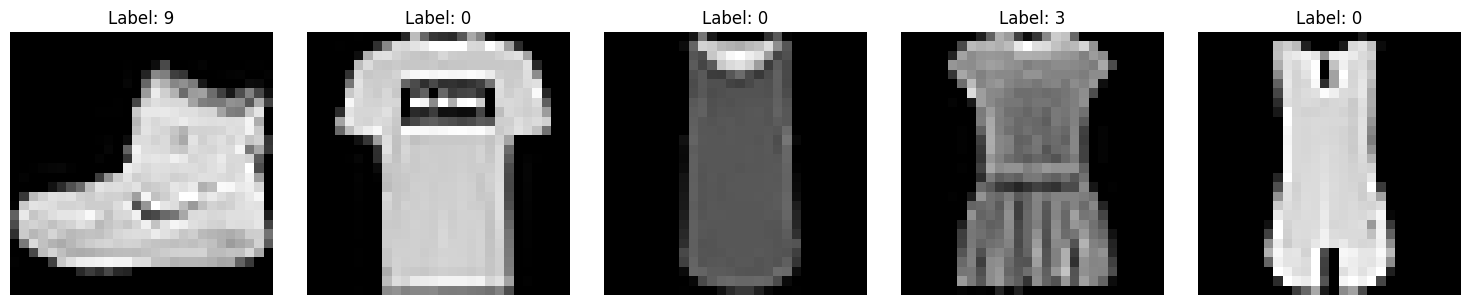

In [86]:
# Plot some examples
fig = plot_mnist_digits(X, y, num_examples=5)
plt.show()

### Data Preprocessing
Scale, split the data and create dataLoaders

In [87]:
def preprocess_data(X, y, batch_size=32, train_size=0.7, val_size=0.15, random_state=42):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split data into train+val and test
    test_size = 1 - train_size - val_size
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X_scaled, y, test_size=test_size,
        random_state=random_state, stratify=y
    )

    # Split train+val into train and val
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval,
        test_size=val_size/(train_size + val_size),
        random_state=random_state, stratify=y_trainval
    )

    # Convert to tensors and create dataloaders
    loaders = {
        'train': DataLoader(
            TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train)),
            batch_size=batch_size, shuffle=True
        ),
        'val': DataLoader(
            TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val)),
            batch_size=batch_size
        ),
        'test': DataLoader(
            TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test)),
            batch_size=batch_size
        )
    }

    data_loader_train = loaders['train']
    data_loader_val = loaders['val']
    data_loader_test = loaders['test']

    return data_loader_train, data_loader_val, data_loader_test

### Model
Create a simple model with right input output and define criterion and criterion/loss

In [88]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def create_model(device):

    model = nn.Sequential(
                nn.Linear(784, 512),
                nn.ReLU(),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 10)
                ).to(device)

    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    return model, criterion, optimizer

### Train
Create a loop to train your model

In [89]:
# Create model and training components
from collections import defaultdict

model, criterion, optimizer = create_model(device)
data_loader_train, data_loader_val, data_loader_test = preprocess_data(X, y, batch_size=32, train_size=0.7, val_size=0.15, random_state=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the model
history = train_model(
    device = device,
    model=model,
    train_loader= data_loader_train ,
    val_loader=data_loader_val,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10
)

Epoch 1/10
------------------------------
Train Loss: 0.4612, Train Accuracy: 0.8322
Validation Loss: 0.4076, Validation Accuracy: 0.8520

Epoch 2/10
------------------------------
Train Loss: 0.3456, Train Accuracy: 0.8734
Validation Loss: 0.3882, Validation Accuracy: 0.8596

Epoch 3/10
------------------------------
Train Loss: 0.3037, Train Accuracy: 0.8867
Validation Loss: 0.3771, Validation Accuracy: 0.8708

Epoch 4/10
------------------------------
Train Loss: 0.2788, Train Accuracy: 0.8951
Validation Loss: 0.3526, Validation Accuracy: 0.8770

Epoch 5/10
------------------------------
Train Loss: 0.2502, Train Accuracy: 0.9050
Validation Loss: 0.3708, Validation Accuracy: 0.8762

Epoch 6/10
------------------------------
Train Loss: 0.2335, Train Accuracy: 0.9137
Validation Loss: 0.3628, Validation Accuracy: 0.8828

Epoch 7/10
------------------------------
Train Loss: 0.2179, Train Accuracy: 0.9184
Validation Loss: 0.3865, Validation Accuracy: 0.8728

Epoch 8/10
----------------

In [90]:
def plot_training_history(history):
    """
    Plot training history

    Parameters:
    -----------
    history : dict
        Training history containing metrics
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    # Plot loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracy
    ax2.plot(history['train_acc'], label='Train Acc')
    ax2.plot(history['val_acc'], label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    return fig

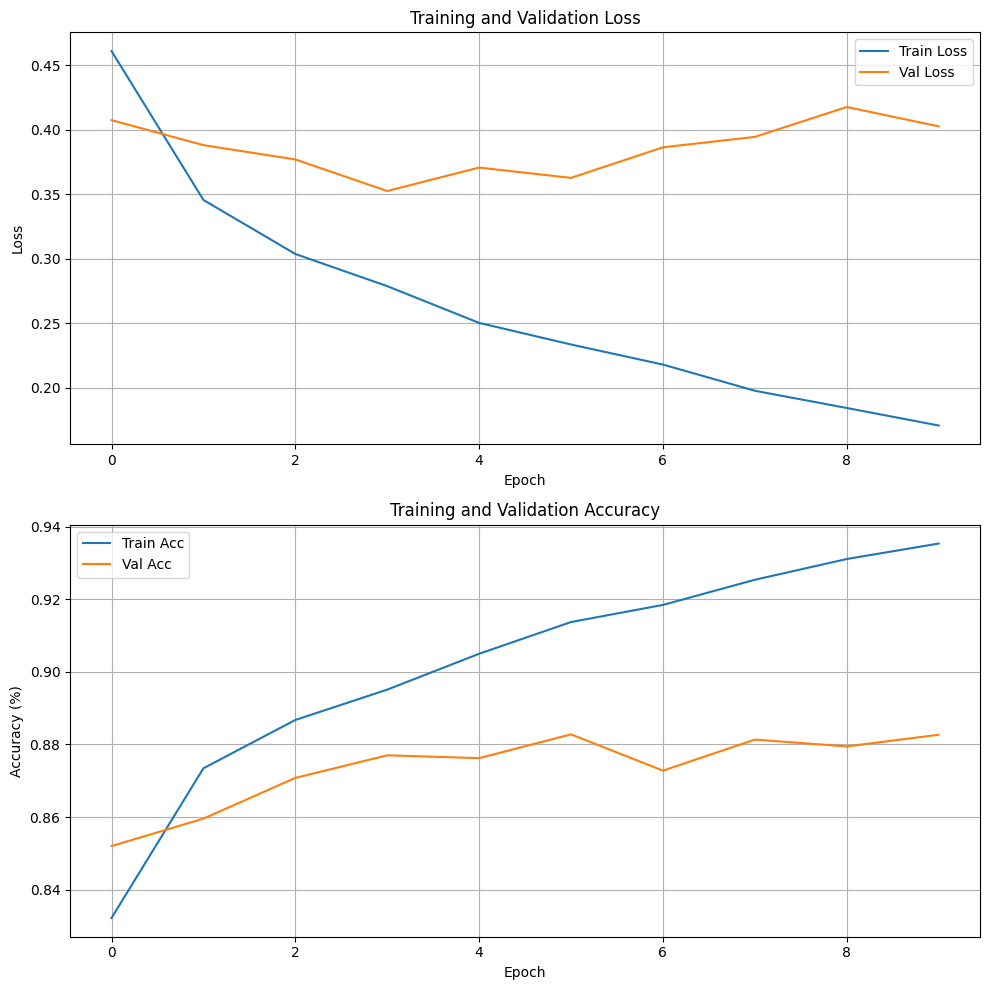

In [92]:
# Plot training history
plot_training_history(history)
plt.show()

In [93]:
### Improve your model and trainning

Epoch 1/10
------------------------------
Train Loss: 0.5352, Train Accuracy: 0.8088
Validation Loss: 0.3919, Validation Accuracy: 0.8583

Epoch 2/10
------------------------------
Train Loss: 0.4170, Train Accuracy: 0.8501
Validation Loss: 0.3664, Validation Accuracy: 0.8634

Epoch 3/10
------------------------------
Train Loss: 0.3803, Train Accuracy: 0.8621
Validation Loss: 0.3684, Validation Accuracy: 0.8620

Epoch 4/10
------------------------------
Train Loss: 0.3549, Train Accuracy: 0.8699
Validation Loss: 0.3385, Validation Accuracy: 0.8781

Epoch 5/10
------------------------------
Train Loss: 0.3348, Train Accuracy: 0.8796
Validation Loss: 0.3458, Validation Accuracy: 0.8729

Epoch 6/10
------------------------------
Train Loss: 0.3176, Train Accuracy: 0.8819
Validation Loss: 0.3261, Validation Accuracy: 0.8823

Epoch 7/10
------------------------------
Train Loss: 0.3042, Train Accuracy: 0.8870
Validation Loss: 0.3317, Validation Accuracy: 0.8794

Epoch 8/10
----------------

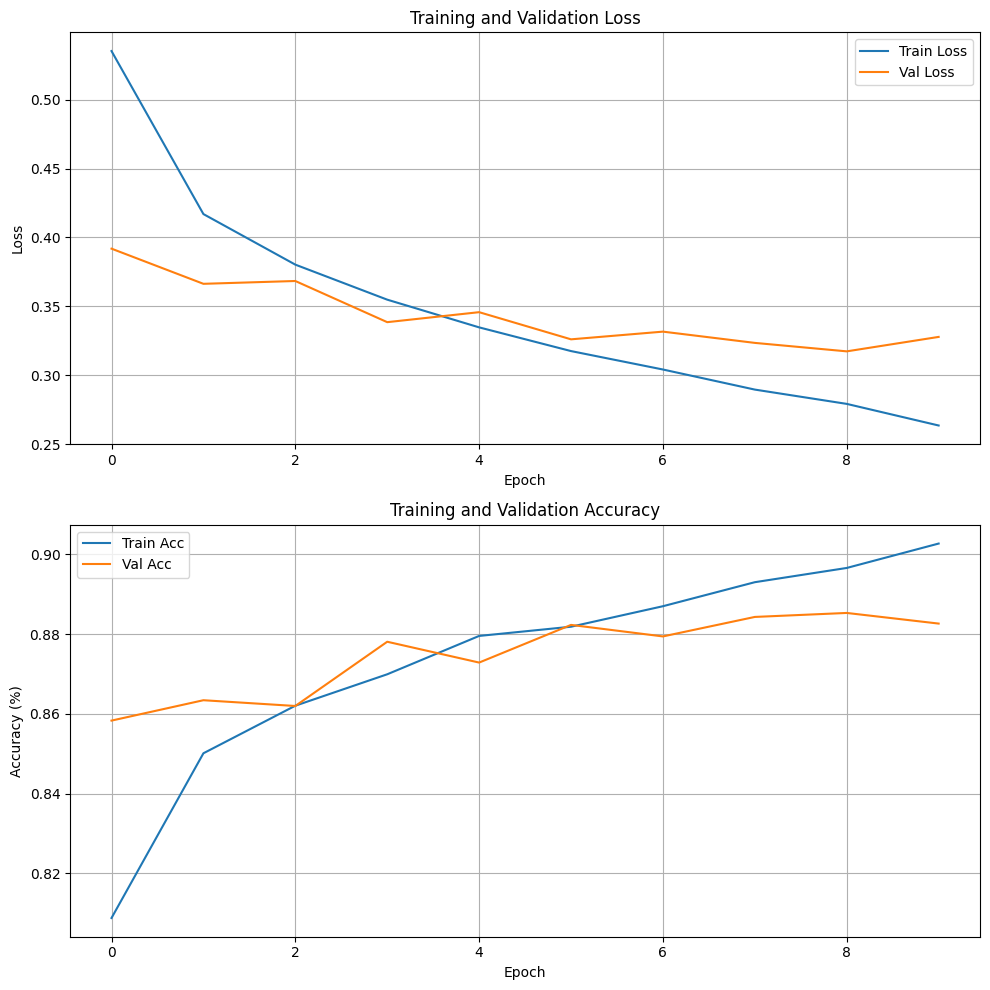

In [94]:
def create_model(device):
    dropout_rate = 0.2
    model = nn.Sequential(
                # First hidden layer
                nn.Linear(784, 512),
                nn.ReLU(),
                nn.BatchNorm1d(512),
                nn.Dropout(dropout_rate),

                # Second hidden layer
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.BatchNorm1d(256),
                nn.Dropout(dropout_rate),

                # Third hidden layer
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.BatchNorm1d(128),
                nn.Dropout(dropout_rate),

                # Output layer
                nn.Linear(128, 10)
            ).to(device)

    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    return model, criterion, optimizer

# Create model and training components
from collections import defaultdict

model, criterion, optimizer = create_model(device)
data_loader_train, data_loader_val, data_loader_test = preprocess_data(X, y, batch_size=32, train_size=0.7, val_size=0.15, random_state=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the model
history = train_model(
    device = device,
    model=model,
    train_loader= data_loader_train ,
    val_loader=data_loader_val,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10
)

plot_training_history(history)
plt.show()

### Generating Submission File

In [95]:
X_test = pd.read_csv('module7_exercise_test_features.csv')
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

In [96]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = model(X_test_tensor)

In [97]:
_, predicted_labels = torch.max(predictions, dim=1)

In [98]:
submission = pd.DataFrame({
    'index': X_test.index,
    'label': 0 # predicted_labels
})

submission.to_csv('submission.csv', index=False, sep=',')
submission.head()

,index,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
